In [1]:
# import pandas as pd
import numpy as np
from numpy import sort
import numerapi
import pandas as pd
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression, SGDRegressor



from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import VotingRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
import plotly.express as px

In [2]:
# Get your API keys and model_id from https://numer.ai/submit
public_id = ""
secret_key = ""
napi = numerapi.NumerAPI(public_id=public_id, secret_key=secret_key)

In [3]:
## download and create a subfolder with the relevant files.
napi = numerapi.NumerAPI(verbosity='info')
napi.download_current_dataset(unzip=True)


2021-05-16 19:21:26,162 INFO numerapi.utils: target file already exists
2021-05-16 19:21:26,162 INFO numerapi.utils: download complete
2021-05-16 19:21:26,164 INFO numerapi.base_api: unzipping file...


'.\\numerai_dataset_264.zip'

In [3]:
## Locally saved csv files
TRAINING_DATAPATH = r'D:\OneDrive\Numer.ai ML\Numerai_Prediction\numerai_dataset_269\numerai_training_data.csv'
TOURNAMENT_DATAPATH = r'D:\OneDrive\Numer.ai ML\Numerai_Prediction\numerai_dataset_269\numerai_tournament_data.csv'

df_train = pd.read_csv(TRAINING_DATAPATH)
df_tournament = pd.read_csv(TOURNAMENT_DATAPATH)
df_test = df_tournament.query('data_type == "validation"')

In [5]:
# Feature columns
features = df_train.columns[df_train.columns.str.startswith('feature')]

# Target column
target = df_train.columns[df_train.columns.str.startswith('target')]

X_train, y_train, X_test, y_test = df_train[features], df_train[target], df_test[features], df_test[target]
X_tour = df_tournament[features]

In [6]:
X_train = X_train.astype(np.float16)
y_train = y_train.astype(np.float16)
X_test = X_test.astype(np.float16)
y_test = y_test.astype(np.float16)
X_tour = X_tour.astype(np.float16)

## Feature selection

### Using univariate Selection

In [ ]:
def scoring(X_train, k):

    #apply SelectKBest class to extract top k best features
    bestfeatures = SelectKBest(score_func=f_regression, k=k)
    fit = bestfeatures.fit(X_train, np.array(y_train).ravel())

    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X_train.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    top_features = featureScores.nlargest(k,'Score').reset_index().drop(columns=['index','Score']).values.ravel()
    X_train_red = X_train[top_features]
    X_test_red = X_test[top_features]
    
    # create a model and fit the training data
    reg = XGBRegressor(n_estimators=100, learning_rate=0.05,tree_method='gpu_hist', gpu_id=0, predictor="gpu_predictor")
    reg.fit(X_train_red, y_train, eval_set=[(X_test_red, y_test)], early_stopping_rounds=10, verbose=False)

    # Evaluate the model
    reg_test_predict = reg.predict(X_test_red)
    score = r2_score(y_test, reg_test_predict)
    return score

In [ ]:
score = 0
n_features = 0
for i  in range(10, X_train.shape[1], 1):
    if scoring(X_train, i) > score:
        print(f'n_features={i}, test_R2_Score:{scoring(X_train, i)}')
        score = scoring(X_train, i)
        n_features = i

### Fit model using each importance as a threshold

In [19]:
reg = XGBRegressor(n_estimators=100, learning_rate=0.05,tree_method='gpu_hist', gpu_id=0, predictor="gpu_predictor")
reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)

thresholds = sort(reg.feature_importances_)

In [23]:
score_1 = 0
thresh_final = 0
score_df = []

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(reg, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    select_X_test = selection.transform(X_test)
    # train model
    selection_model = XGBRegressor(n_estimators=100, learning_rate=0.05,tree_method='gpu_hist', gpu_id=0, predictor="gpu_predictor")
    selection_model.fit(select_X_train, y_train, eval_set=[(select_X_test, y_test)], early_stopping_rounds=10, verbose=False)
    # eval model
    y_pred = selection_model.predict(select_X_test)
    sel_score = selection_model.score(select_X_test, y_test)
    score_df.append(sel_score)
    if sel_score >= score_1:
        print(f'Thresh={thresh}, n={select_X_train.shape[1]}, R2_Score:{sel_score}')
        score_1 = sel_score
        thresh_final = thresh

Thresh=0.0, n=310, R2_Score:0.0004970249768639912
Thresh=0.0022308139596134424, n=306, R2_Score:0.0005250505954897955
Thresh=0.0022736333776265383, n=304, R2_Score:0.0005320121398590949
Thresh=0.002276350511237979, n=303, R2_Score:0.0005324137345810165
Thresh=0.002449332270771265, n=290, R2_Score:0.0005551457721887365
Thresh=0.00266346987336874, n=273, R2_Score:0.0005610007563897623
Thresh=0.0027703181840479374, n=250, R2_Score:0.0005661058133703545
Thresh=0.0027722823433578014, n=249, R2_Score:0.000580597658483839
Thresh=0.0027740022633224726, n=247, R2_Score:0.000596904131891951


In [ ]:
# plt.semilogy(score_df)
# plt.xlabel('alpha')
# plt.ylabel('r2_score')
# plt.grid()
# plt.show()


fig = px.line(np.array(score_df), range_x=[1, 200])
fig.show()

## Select top features

In [7]:
#apply threshold importance to extract top k best features
threshold=0.0027740022633224726
reg = XGBRegressor(n_estimators=100, learning_rate=0.05,tree_method='gpu_hist', gpu_id=0, predictor="gpu_predictor")
reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)
selection = SelectFromModel(reg, threshold=threshold, prefit=True)
X_train_red = selection.transform(X_train)
X_test_red = selection.transform(X_test)
X_tour_red = selection.transform(X_tour)

In [8]:
del reg

## Defining cross-validation strategy

In [15]:
n_folds = 3

def r2_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=1234).get_n_splits(X_train_red)
    r2= cross_val_score(model, X_train_red, y_train, scoring="r2", cv = kf)
    return(r2)

## Lasso Regression Model

### Tune parameters

,0.001000,0.000500,0.000250,0.000100,0.000050,0.000025,0.000010
R2,0.000034,0.000628,0.001031,0.001074,0.000999,0.000836,0.000622


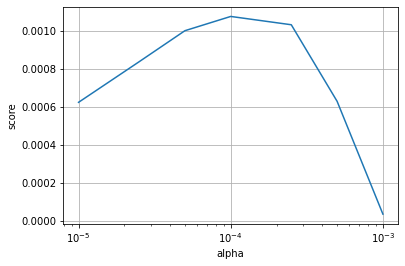


Lasso Score: 0.001074 (alpha = 0.00010)



In [16]:
lasso_alpha = [0.001, 0.0005, 0.00025, 0.0001, 0.00005, 0.000025, 0.00001]
lasso_r2 = []

for value in lasso_alpha:
    lasso = Lasso(alpha = value, max_iter=3000, random_state = 1234)
    lasso_r2.append(r2_cv(lasso).mean())
    
lasso_score_table = pd.DataFrame(lasso_r2, lasso_alpha, columns=['R2'])
display(lasso_score_table.transpose())

plt.semilogx(lasso_alpha, lasso_r2)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid()
plt.show()

print("\nLasso Score: {:.6f} (alpha = {:.5f})\n".format(max(lasso_score_table['R2']), lasso_score_table.idxmax()[0]))

### Train the model

In [10]:
lasso = Lasso(alpha = 0.0001, random_state = 1234)
lasso.fit(X_train_red, y_train)

# Predictions
lin_train_predict = lasso.predict(X_train_red)
lin_test_predict = lasso.predict(X_test_red)

# Evaluate the model
print('Model performance on training set:')
score = r2_score(y_train, lin_train_predict)
print(f'Training R^2: {score}')

print('Model performance on testing set:')
score_lin = r2_score(y_test, lin_test_predict)
print(f'Test R^2: {score_lin}')

Model performance on training set:
Training R^2: 0.0019357626899714209
Model performance on testing set:
Test R^2: -0.00022612983704628498


## Ridge Regression Model

### Tune parameters

,33000,35000,37000
R2,0.001151,0.001151,0.001149


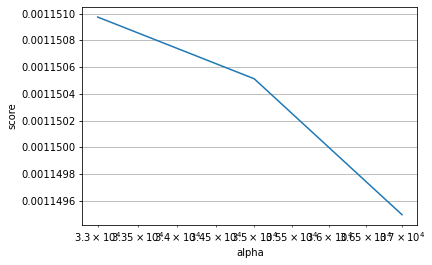


Ridge Score: 0.001151 (alpha = 33000.00000)



In [19]:
ridge_alpha = [33000, 35000, 37000]
ridge_r2 = []

for value in ridge_alpha:
    ridge = Ridge(alpha = value, max_iter=3000, random_state = 1234)
    ridge_r2.append(r2_cv(ridge).mean())
    
ridge_score_table = pd.DataFrame(ridge_r2,ridge_alpha,columns=['R2'])
display(ridge_score_table.transpose())

plt.semilogx(ridge_alpha, ridge_r2)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid()
plt.show()

print("\nRidge Score: {:.6f} (alpha = {:.5f})\n".format(max(ridge_score_table['R2']), ridge_score_table.idxmax()[0]))

### Train the model

In [11]:
ridge = Ridge(alpha = 33000, random_state = 1234)
ridge.fit(X_train_red, y_train)

# Predictions
ridge_train_predict = ridge.predict(X_train_red)
ridge_test_predict = ridge.predict(X_test_red)

# Evaluate the model
print('Model performance on training set:')
score = r2_score(y_train, ridge_train_predict)
print(f'Training R^2: {score}')

print('Model performance on testing set:')
score_ridge = r2_score(y_test, ridge_test_predict)
print(f'Test R^2: {score_ridge}')

Model performance on training set:
Training R^2: 0.0019028077840615998
Model performance on testing set:
Test R^2: -0.00017516939666717413


## XGB model

### Tune parameters

In [65]:
parameters = {'max_depth': [5],
            'min_child_weight': [2, 4],
            'learning_rate': [0.05, 0.1],
            'gamma': [0.2],
            'n_estimators': [100, 500]
            }
reg = XGBRegressor(tree_method='gpu_hist', gpu_id=0, predictor="gpu_predictor")
clf = GridSearchCV(reg, parameters, scoring='r2', verbose=3, cv=2)

clf.fit(X_train_red, y_train)
display(clf.best_params_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=2, n_estimators=100;, score=0.002 total time=   5.8s
[CV 2/2] END gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=2, n_estimators=100;, score=0.001 total time=   6.2s
[CV 1/2] END gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=2, n_estimators=500;, score=0.002 total time=  12.7s
[CV 2/2] END gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=2, n_estimators=500;, score=0.001 total time=  13.3s
[CV 1/2] END gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=4, n_estimators=100;, score=0.002 total time=   5.7s
[CV 2/2] END gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=4, n_estimators=100;, score=0.001 total time=   6.1s
[CV 1/2] END gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=4, n_estimators=500;, score=0.002 total time=  12.7s
[CV 2/2] END gamma=0.2, learning_rate=0.05, max_dep

{'gamma': 0.2,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 2,
 'n_estimators': 500}

### Train the model

In [66]:
reg = XGBRegressor(n_estimators=500, learning_rate=0.05, gamma=0.2, max_depth=5, min_child_weight=2, tree_method='gpu_hist', gpu_id=0, predictor="gpu_predictor")
reg.fit(X_train_red, y_train, eval_set=[(X_test_red, y_test)], early_stopping_rounds=50, verbose=False)

# Predictions
reg_train_predict = reg.predict(X_train_red)
reg_test_predict = reg.predict(X_test_red)

# Evaluate the model
print('Model performance on training set:')
score = r2_score(y_train, reg_train_predict)
print(f'Training R^2: {score}')

print('Model performance on testing set:')
score_xgb = r2_score(y_test, reg_test_predict)
print(f'Test R^2: {score_xgb}')

Model performance on training set:
Training R^2: 0.005242804323534966
Model performance on testing set:
Test R^2: 0.0006414925245884495


In [70]:
import pickle
# save model to file
pickle.dump(reg, open("reg.pickle.dat", "wb"))

del reg

## ElasticNet model

### Tune parameters

,0.1,1000.0,10000.0
R2,-4.328540e-08,-4.328540e-08,-4.328540e-08


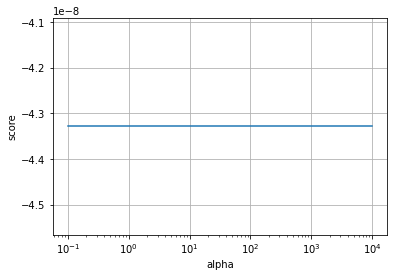


ElasticNet Score: -0.000000 (alpha = 0.10000)



In [26]:
en_alpha = [0.1, 1000, 10000]
en_r2 = []

for value in en_alpha:
    en = ElasticNet(alpha= value, max_iter=3000, random_state = 1234)
    en_r2.append(r2_cv(en).mean())
    
en_score_table = pd.DataFrame(en_r2,en_alpha,columns=['R2'])
display(en_score_table.transpose())

plt.semilogx(en_alpha, en_r2)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid()
plt.show()

print("\nElasticNet Score: {:.6f} (alpha = {:.5f})\n".format(max(en_score_table['R2']), en_score_table.idxmax()[0]))

### Train the model

In [27]:
en = ElasticNet()
en.fit(X_train_red, y_train)

# Predictions
en_train_predict = en.predict(X_train_red)
en_test_predict = en.predict(X_test_red)

# Evaluate the model
print('Model performance on training set:')
score = r2_score(y_train, en_train_predict)
print(f'Training R^2: {score}')

print('Model performance on testing set:')
score_ridge = r2_score(y_test, en_test_predict)
print(f'Test R^2: {score_ridge}')

Model performance on training set:
Training R^2: 1.79248504927898e-10
Model performance on testing set:
Test R^2: -1.916352188047199e-09


## Ensemble model

In [28]:
models = [('elnet', ElasticNet()), ('reg', XGBRegressor(n_estimators=100, learning_rate=0.05, gamma=0.2, max_depth=5, min_child_weight=2, tree_method='gpu_hist', gpu_id=0, predictor="gpu_predictor"))]

### Stacked generalization

In [15]:
final_estimator = GradientBoostingRegressor(n_estimators=100, subsample=0.5, min_samples_leaf=50, max_features='sqrt')
stack_reg = StackingRegressor(estimators=models, final_estimator=final_estimator)

In [16]:
stack_reg.fit(X_train_red, np.array(y_train).ravel())

# Predictions
stack_reg_train_predict = stack_reg.predict(X_train_red)
stack_reg_test_predict = stack_reg.predict(X_test_red)

# Evaluate the model
print('Model performance on training set:')
score = r2_score(y_train, stack_reg_train_predict)
print(f'Training R^2: {score}')

print('Model performance on testing set:')
score = r2_score(y_test, stack_reg_test_predict)
print(f'Test R^2: {score}')

Model performance on training set:
Training R^2: 0.007086868212322628
Model performance on testing set:
Test R^2: 0.00038263513472847066


## Tournament predictions

In [10]:
import pickle
# load model from file
reg = pickle.load(open("reg.pickle.dat", "rb"))

In [11]:
tournament_predictions = reg.predict(X_tour_red)

# predictions must have an `id` column and a `prediction` column
predictions_df = df_tournament["id"].to_frame()
predictions_df["prediction"] = tournament_predictions
predictions_df.to_csv('Predictions_main_incl_val.csv', index=False)
predictions_df.shape

(1720183, 2)

In [12]:
# Get your API keys and model_id from https://numer.ai/submit
public_id = ""
secret_key = ""
napi = numerapi.NumerAPI(public_id=public_id, secret_key=secret_key)

submission_id = napi.upload_predictions("Predictions_main_incl_val.csv", model_id='')

2021-05-16 23:10:46,196 INFO numerapi.base_api: uploading predictions...


In [15]:
submission_id = napi.upload_predictions("Predictions_main.csv", model_id='')

2021-05-16 21:45:42,077 INFO numerapi.base_api: uploading predictions...
